Code to calibrate market prices and futures prices for VIX and Variance futures

In [ ]:

# Prepare data
vix_futures = [
    {'days': 0, 'settlement': 22.6694},
    {'days': 12, 'settlement': 22.3484},
    {'days': 40, 'settlement': 21.8897},
    {'days': 68, 'settlement': 21.7491},
    {'days': 103, 'settlement': 21.7805},
    {'days': 131, 'settlement': 21.8737},
    {'days': 166, 'settlement': 22.0178},
    {'days': 194, 'settlement': 22.1365},
    {'days': 222, 'settlement': 22.2502}
]

variance_futures = [
    {'remaining_days': 4, 'total_days': 123, 'elapsed_days': 119, 'settlement': 579.58, 'accrued': 582.219},
    {'remaining_days': 27, 'total_days': 186, 'elapsed_days': 159, 'settlement': 476.95, 'accrued': 470.917},
    {'remaining_days': 46, 'total_days': 123, 'elapsed_days': 77, 'settlement': 699.11, 'accrued': 805.347},
    {'remaining_days': 66, 'total_days': 120, 'elapsed_days': 54, 'settlement': 783.27, 'accrued': 1092.85},
    {'remaining_days': 90, 'total_days': 124, 'elapsed_days': 34, 'settlement': 796.14, 'accrued': 1474.92},
    {'remaining_days': 110, 'total_days': 125, 'elapsed_days': 15, 'settlement': 517.64, 'accrued': 300.293},
    {'remaining_days': 154, 'total_days': 313, 'elapsed_days': 159, 'settlement': 515.90, 'accrued': 470.908},
    {'remaining_days': 277, 'total_days': 372, 'elapsed_days': 95, 'settlement': 619.76, 'accrued': 691.246}
]


`xtol` termination condition is satisfied.
Function evaluations 24, initial cost 1.3681e-01, final cost 2.0765e-04, first-order optimality 6.50e-04.

JOINT calibration  (weights = price)
  V_t   =  0.048965
  λ     =  1.411145
  θ     =  0.071045
  ξ     =  0.283655
  RMS   =  0.004943


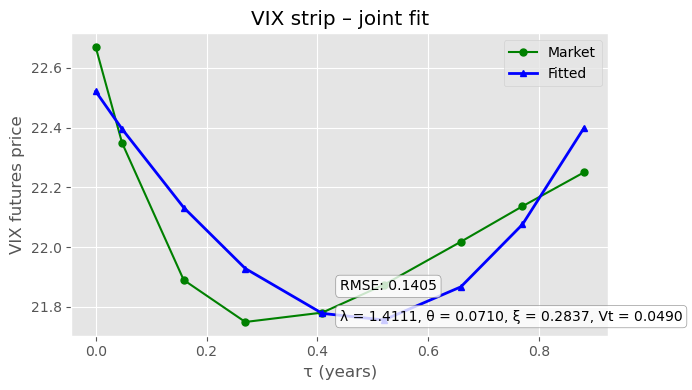

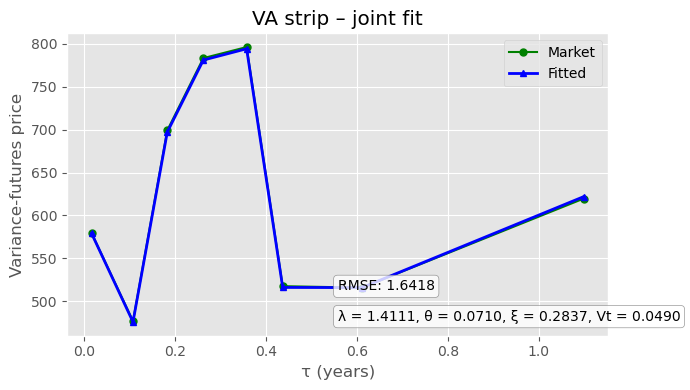


VIX Futures Prices:
Days | Market Price | Model Price | Difference
---------------------------------------------
   0 |     22.6694 |     22.5212 |    -0.1482
  12 |     22.3484 |     22.3951 |     0.0467
  40 |     21.8897 |     22.1322 |     0.2425
  68 |     21.7491 |     21.9281 |     0.1790
 103 |     21.7805 |     21.7778 |    -0.0027
 131 |     21.8737 |     21.7558 |    -0.1179
 166 |     22.0178 |     21.8667 |    -0.1511
 194 |     22.1365 |     22.0757 |    -0.0608
 222 |     22.2502 |     22.3992 |     0.1490

Variance Futures Prices:
Remaining Days | Market Price | Model Price | Difference
-----------------------------------------------------
             4 |    579.5800 |    579.2886 |    -0.2914
            27 |    476.9500 |    475.9422 |    -1.0078
            46 |    699.1100 |    697.0606 |    -2.0494
            66 |    783.2700 |    781.0058 |    -2.2642
            90 |    796.1400 |    794.1811 |    -1.9589
           110 |    517.6400 |    516.1660 |    -1.4740

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate
from scipy.optimize import minimize, differential_evolution, least_squares
from scipy.integrate import quad
import datetime
from VIX import compute_vix_futures
from Variance import compute_variance_futures

# Extract market prices and time parameters
y_market = np.array([f['settlement'] for f in vix_futures])
p_market = np.array([f['settlement'] for f in variance_futures])

# Time parameters in years (using 252 trading days per year)
tau_mkt = np.array([f['days']/252.0 for f in vix_futures])
tau_var = np.array([f['remaining_days']/252.0 for f in variance_futures])
T_vec = np.array([f['total_days']/252.0 for f in variance_futures])
# Convert annualized accrued variance to integrated accrued variance
accr_int = np.array([
    f['accrued'] * f['elapsed_days'] / 252.0 
    for f in variance_futures
])

# Define model_prices_all function using your compute_vix_futures and compute_variance_futures
def model_prices_all(params):
    V_t, lam, theta, xi = params
    
    # Compute VIX futures prices using your function
    vix_pred = np.array([
        compute_vix_futures(V_t, lam, theta, xi, t, 30/252.0) 
        for t in tau_mkt
    ])
    
    # Compute variance futures prices using your function
    va_pred = np.array([
        compute_variance_futures(V_t, lam, theta, xi, t, Ti, a)
        for t, Ti, a in zip(tau_var, T_vec, accr_int)
    ])
    
    return np.concatenate([vix_pred, va_pred])

# Combine all market prices
y_all = np.concatenate([y_market, p_market])

# Define weighting scheme (inverse price for percentage error)
weighting = "price"  # "none" or "price"
w_all = (1 / y_all) if weighting == "price" else np.ones_like(y_all)

# Define residuals function for least squares optimization
def residuals_all(params, market, weights):
    return weights * (model_prices_all(params) - market)

# Initial parameter guess and bounds
x0 = np.array([0.05, 1.5, 0.05, 0.25])  # [V_t, λ, θ, ξ]
bounds = (np.full_like(x0, 0.005), np.full_like(x0, 10))

# Run optimization
result = least_squares(
    residuals_all, 
    x0, 
    bounds=bounds,
    args=(y_all, w_all), 
    verbose=1,
    ftol=1e-8,
    xtol=1e-8
)

# Extract optimized parameters
V_t_hat, lam_hat, theta_hat, xi_hat = result.x
rms = np.sqrt(result.cost*2/len(y_all))

print(f"\nJOINT calibration  (weights = {weighting})")
print(f"  V_t   = {V_t_hat:9.6f}")
print(f"  λ     = {lam_hat:9.6f}")
print(f"  θ     = {theta_hat:9.6f}")
print(f"  ξ     = {xi_hat:9.6f}")
print(f"  RMS   = {rms:9.6f}")

# Calculate fitted prices
fitted_prices = model_prices_all(result.x)
fitted_vix = fitted_prices[:len(y_market)]
fitted_va = fitted_prices[len(y_market):]

# ────────────────────────── plots ──────────────────────────
plt.style.use("ggplot")

# Calculate RMSE for VIX and VA
vix_rmse = np.sqrt(np.mean((y_market - fitted_vix)**2))
va_rmse = np.sqrt(np.mean((p_market - fitted_va)**2))

# Format parameter string for display
param_text = f"λ = {lam_hat:.4f}, θ = {theta_hat:.4f}, ξ = {xi_hat:.4f}, Vt = {V_t_hat:.4f}"

# VIX
plt.figure(figsize=(7,4))
plt.plot(tau_mkt, y_market, 'g-o', label="Market", markersize=5)
plt.plot(tau_mkt, fitted_vix, 'b-^', lw=2, label="Fitted", markersize=5)
plt.xlabel("τ (years)")
plt.ylabel("VIX futures price")
plt.title("VIX strip – joint fit")
plt.annotate(param_text, xy=(0.5, 0.05), xycoords='axes fraction', 
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
plt.annotate(f"RMSE: {vix_rmse:.4f}", xy=(0.5, 0.15), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
plt.legend()
plt.tight_layout()
plt.show()

# VA
plt.figure(figsize=(7,4))
plt.plot(tau_var, p_market, 'g-o', label="Market", markersize=5)
plt.plot(tau_var, fitted_va, 'b-^', lw=2, label="Fitted", markersize=5)
plt.xlabel("τ (years)")
plt.ylabel("Variance-futures price")
plt.title("VA strip – joint fit")
plt.annotate(param_text, xy=(0.5, 0.05), xycoords='axes fraction', 
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
plt.annotate(f"RMSE: {va_rmse:.4f}", xy=(0.5, 0.15), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
plt.legend()
plt.tight_layout()
plt.show()

# Print a table of market vs model prices
print("\nVIX Futures Prices:")
print("Days | Market Price | Model Price | Difference")
print("-" * 45)
for i, f in enumerate(vix_futures):
    print(f"{f['days']:4d} | {y_market[i]:11.4f} | {fitted_vix[i]:11.4f} | {fitted_vix[i] - y_market[i]:10.4f}")

print("\nVariance Futures Prices:")
print("Remaining Days | Market Price | Model Price | Difference")
print("-" * 53)
for i, f in enumerate(variance_futures):
    print(f"{f['remaining_days']:14d} | {p_market[i]:11.4f} | {fitted_va[i]:11.4f} | {fitted_va[i] - p_market[i]:10.4f}")
